## Learning with a single neuron

In this notebook, we'll build a neuron that classifies an image as an apple or as a banana using multiple features from the image. We'll **train** our neuron using data from many images that have already been correctly categorised; our neuron will thereby **learn** what parameters to use, by minimizing a loss function using gradient descent.

We'll do this with almost the simplest possible neuron, namely one that takes just two inputs:

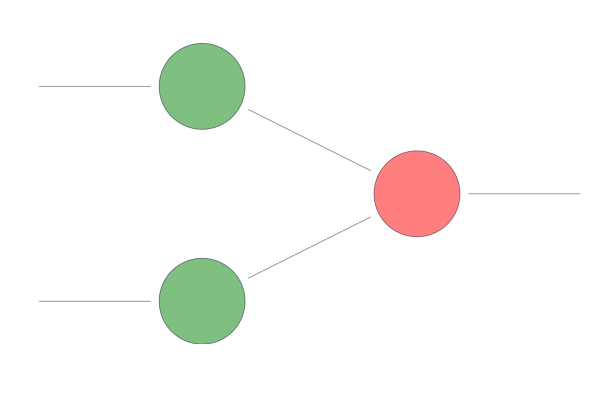

In [1]:
include("draw_neural_net.jl")
number_inputs, number_neurons = 2, 1
draw_network([number_inputs, number_neurons])

To do this, we need to work with and *clean* some real data. Let's get started!

## Loading in some data

Let's load in some real data! We'll use data that we have prepared from photos of apples and bananas; it turns out to be stored on disk in data files as "tab-separated values". We can read this data in with the `CSV.jl` package, as follows.

In [6]:
;head data/Apple_Golden_1.dat

height 	 width 	 red 	 green 	 blue
94	99	0.7087030187328474	0.6412822654416733	0.34199790531493207
94	99	0.6483756208349677	0.5531685601966386	0.2841629369864189
94	99	0.6472366384412269	0.5533021621650569	0.2825794945129109
94	99	0.6479628128035707	0.5532301961319531	0.2836893894994881
94	99	0.6476532597771926	0.5540471913956418	0.28459971774969595
94	99	0.6484905327625725	0.5538208305944341	0.28596989081814317
94	99	0.6479735888902249	0.5545183581271632	0.2856463103305404
94	99	0.6493070400883905	0.5543994213991563	0.28732335727267694
95	99	0.6481409779101505	0.5547078418309359	0.2861025982678221


In [7]:
;head data/bananas.dat

height 	 width 	 red 	 green 	 blue
98	99	0.5835067538126356	0.500662309368192	0.20750413943355192
50	99	0.6096658836445241	0.514868541076373	0.18687105966305895
52	99	0.61001222127424	0.5157592947018083	0.18750355493040088
99	69	0.5680333392636676	0.4929391278094967	0.23931596284375803
51	99	0.6097662880271572	0.5148498882514222	0.1833291091603121
53	99	0.6080886893475433	0.5146088965412025	0.1833736532775401
53	99	0.6086763977507786	0.5154866998805462	0.18620604259534498
53	99	0.6092775365179625	0.5164860873506747	0.1885818309426686
99	67	0.5690986557452848	0.4945007761667278	0.24194052691261872


In [5]:
using CSV
using TextParse

applecols, applecolnames = TextParse.csvread("data/Apple_Golden_1.dat", '\t')
bananacols, bananacolnames = TextParse.csvread("data/bananas.dat", '\t');

Next, we want to use `DataFrames` to store the information from our CSV files.

In [8]:
using DataFrames

One way we can create a `DataFrame` is to pass a dictionary that contain arrays as values and descriptive names for those arrays as keys to the `DataFrame` function:

In [9]:
apples =  DataFrame(Dict(strip(name) => col for (name, col) in zip(applecolnames, applecols)))
bananas = DataFrame(Dict(strip(name) => col for (name, col) in zip(bananacolnames, bananacols)))

,blue,green,height,red,width
1,0.207504,0.500662,98,0.583507,99
2,0.186871,0.514869,50,0.609666,99
3,0.187504,0.515759,52,0.610012,99
4,0.239316,0.492939,99,0.568033,69
5,0.183329,0.51485,51,0.609766,99
6,0.183374,0.514609,53,0.608089,99
7,0.186206,0.515487,53,0.608676,99
8,0.188582,0.516486,53,0.609278,99
9,0.241941,0.494501,99,0.569099,67
10,0.189116,0.516183,54,0.610284,99


Above, we used a "dictionary comprehension" to create each `DataFrame`. Here is some code to create a dictionary, `appledict`, via a dictionary comprehension:

```julia
appledict = Dict(strip(name)=>col for (name, col) in zip(applecolnames, applecols))
```
For now, don't worry about the exact syntax used here. Just note that the dictionary created associates names with arrays, and that we've used a dictionary like this to create a `DataFrame` with named columns!

So for now, each of the two data sets is stored in a `DataFrame` (from the `DataFrames.jl` package).

### Roadmap

To use a neuron with two inputs, we will use just two of the data (numbers) for each image, say columns 3 and 4, the mean amount of red and the mean amount of green; each data point will then be a 2-dimensional vector, and the data points lie on a two-dimensional plane. We will have many input data, labelled with an index $i$. We will denote the $i$th data point as  $\mathbf{x}^{(i)}$.

The goal is that our neuron will take a single point on the two-dimensional plane as its input, and should return a single output that **classifies** it as an apple ($0$) or a banana ($1$). 

To do so, it must "**learn**" the correct values of its parameters $\mathbf{w}$ and $b$. For this learning to take place, we'll need **labels** for each of the input data, which identify them as either an apple (0) or as a banana (1). 

These labels will, in turn, allow us to create a loss function, which will allow our algorithm to learn to determine if a given choice of parameters does a good or a poor job of classifying our fruit images. 

**So what do we have left to do?**

The above might sound complex, but luckily we can break it down into a series of actionable steps:

1. Clean our input data (amounts of red and green) to get it into a usable format;
2. Create a sequence of labels that we can use to identify correct and incorrect classifications;
3. Define a loss function that contains parameters;
4. Implement an algorithm to pick parameters for our neuron by minimizing the loss function with respect to the parameters;
5. Use all of the above to train our neuron how to classify images as apples or bananas!

#### Note: 

Note that *in general we cannot expect that a single neuron will be adequate for classification.* 

If a single neuron struggles to classify our images, we may need to use a more complicated neural network structure (which corresponds to using a more complicated function).

## Cleaning the data

Usually it will be necessary to "clean" the data in some way, i.e. pre-process it, before it can be used for whichever task you are interested in.

Our next *meta*-exercise will be to collect all the data from columns 3 and 4 into a *single* Julia vector `x` (of which each entry is itself a vector), and the labels into a single vector `y`. Let's do this in a series of steps!

#### Exercise 1

First, let's practice grabbing a single column of a `DataFrame`. To grab a column, you can index into the `DataFrame` with the name of the column you want, passed as a symbol. In Julia, symbols are names preceded by a `:`. For example, we could grab the "height" column from `apples` by indexing into `apples` with the symbol, `:height`:

```julia
apples[:height]
```

Index into `apples` to get the "red" column. What is the type of the object returned? How many entries does it have?

A) Array, 5 <br>
B) DataArray, 5 <br>
C) Array, 64 <br>
D) DataArray, 64 <br>
E) Array, 492 <br>
F) DataArray, 492

#### Solution

Grab the `red` column via

```julia
apples[:red]
```

The solution is E) `Array, 492`.

In [16]:
apples[:red]

492-element Array{Float64,1}:
 0.708703
 0.648376
 0.647237
 0.647963
 0.647653
 0.648491
 0.647974
 0.649307
 0.648141
 0.64984 
 0.648446
 0.709808
 0.650164
 ⋮       
 0.708358
 0.707738
 0.710167
 0.71019 
 0.712168
 0.712654
 0.71442 
 0.714733
 0.717374
 0.719258
 0.733532
 0.719269

#### Exercise 2

We can grab an individual entry of a `DataFrame` by specifying the row index of the entry and the column symbol. For example, to access the height of the 4th image of an apple, we would execute

```julia
apples[4, :height]
```

How much red is there in the 63rd image of a banana?

#### Solution

We determine the amount of red in the 63rd banana via
```julia
bananas[63, :red]
```

This is equal to `0.4686558882484724`.

In [17]:
bananas[63, :red]

0.4686558882484724

#### Exercise 3

We want to reorganize data from the 3rd and 4th columns of `apples` and `bananas` to put that data in a single array. Let's start by organizing the data from the 3rd and 4th columns of `apples` into a single array, `x_apples`. Create `x_apples` such that there is a single element in `x_apples` for each image in `apples`. The $i^\mathrm{th}$ element in `x_apples` should be a `Vector`, i.e. a 1D `Array`, with two elements - the amount of red and the amount of blue in the $i^\mathrm{th}$ image from `apples`.

Similarly create the `Array` `x_bananas` using data from `bananas`.

#### Solution

Create `x_apples` and `x_bananas` via

```julia
x_apples = [[apples[i, :red], apples[i, :green]] for i in 1:length(apples[:red])]
x_bananas = [[bananas[i, :red], bananas[i, :green]] for i in 1:length(bananas[:red])]
```

**Tests**

```julia
isapprox(x_apples[404][1],  0.6774070822358786)
isapprox(x_apples[404][2], 0.5832823897939495)
isapprox(x_bananas[404][1], 0.5384643155305847)
isapprox(x_bananas[404][2], 0.4738283806042557)
```

In [18]:
x_apples = [[apples[i, :red], apples[i, :green]] for i in 1:length(apples[:red])]
x_bananas = [[bananas[i, :red], bananas[i, :green]] for i in 1:length(bananas[:red])]

490-element Array{Array{Float64,1},1}:
 [0.583507, 0.500662]
 [0.609666, 0.514869]
 [0.610012, 0.515759]
 [0.568033, 0.492939]
 [0.609766, 0.51485] 
 [0.608089, 0.514609]
 [0.608676, 0.515487]
 [0.609278, 0.516486]
 [0.569099, 0.494501]
 [0.610284, 0.516183]
 [0.607329, 0.515344]
 [0.608367, 0.51465] 
 [0.606331, 0.513778]
 ⋮                   
 [0.52913, 0.44031]  
 [0.528731, 0.456548]
 [0.524028, 0.452379]
 [0.523906, 0.452571]
 [0.523823, 0.4514]  
 [0.522489, 0.449973]
 [0.517573, 0.444391]
 [0.515956, 0.441912]
 [0.517585, 0.444827]
 [0.510357, 0.436022]
 [0.508873, 0.43433] 
 [0.528205, 0.440139]

#### Exercise 4

Next we want to combine the elements of `x_apples` and `x_bananas` into a single array, `xs`. `xs` should contain, first, all the elements of `x_apples`, and then all the elements of `x_bananas`. Use the `vcat` function to create `xs`.

#### Solution

The following will produce the desired `xs`:

```julia
xs = vcat(x_apples, x_bananas)
```

**Tests**

```julia
isapprox(xs[404][1], 0.6774070822358786)
isapprox(xs[404][2], 0.5832823897939495)
isapprox(xs[808][1], 0.5771131704577359)
isapprox(xs[808][2], 0.4821497596511228)
```

#### Exercise 5

If you've gotten this far, our data is in the format we want for learning. Now we need labels! We want to store a label (either a `0` or a `1` for every apple or banana image in our data set in an array called `ys`. Recall that "0" refers to an apple and "1" refers to a banana.

Create an array `ys` where the $i^\mathrm{th}$ element of `ys` is a `0` if the $i^\mathrm{th}$ element of `xs` is an apple, and where the $i^\mathrm{th}$ element of `ys` is a `1` if the $i^\mathrm{th}$ element of `xs` is a banana.

#### Solution

You can generate `ys` via 
```julia
ys = [0 for i in 1:length(x_apples)]
ys = vcat(ys, [1 for i in 1:length(x_bananas)])
```

**Tests**

```julia
ys[1] == 0
ys[492] == 0
ys[493] == 1
ys[982] == 1
```

#### Exercise 6

Add data points for all apple and banana images in our data sets to a plot using `scatter`. Plot data points for apples in one color and use a different color for banana data points.

Hint: You may want to use the `first` and `last` functions.

#### Solution

The following code will produce the desired plot:

```julia
scatter(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), label="bananas")
```

## "Learning" by hand

Intuitively, looking at the plot of the data, we see that it should be "easy" to find a function that separates the data into bananas on one side and apples on the other: we just need to draw a straight line that divides the two clouds of data. We can do this "by hand", as follows.

In the code below, the neuron will learn a function of the form $\sigma(\mathbf{w} \cdot \mathbf{x} + b)$. Since $\sigma$ looks like a smooth version of a step function, we can think of $\sigma$ classifying based on whether the value of its output argument is less than `0.5` or greater than `0.5`. 

**Game**: Use the interactive visualization to find suitable values of $\mathbf{w}$ and $b$ such that the hyperplane $\sigma(w_1 x_1 + w_2 x_2 + b) = 0.5$ divides the data. This is the same as the hyperplane for which $w_1 x_1 + w_2 x_2 + b = 0$ ! (Note that there are many such values!)

We can solve for $x_2$ via 

$$x_2 = -(w_1 x_1 + b) / w_2,$$

and use this to draw the corresponding hyperplane.

In [19]:
using Interact

Interact.Options{:SelectionSlider,Float64}(1: "input" = 0.5 Float64 , "w1", 0.5, "0.5", 251, Interact.OptionDict(DataStructures.OrderedDict("-2.0"=>-2.0,"-1.99"=>-1.99,"-1.98"=>-1.98,"-1.97"=>-1.97,"-1.96"=>-1.96,"-1.95"=>-1.95,"-1.94"=>-1.94,"-1.93"=>-1.93,"-1.92"=>-1.92,"-1.91"=>-1.91…), Dict(-0.92=>"-0.92",1.2=>"1.2",2.37=>"2.37",1.68=>"1.68",-0.22=>"-0.22",-1.78=>"-1.78",1.19=>"1.19",-1.23=>"-1.23",0.22=>"0.22",2.75=>"2.75"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:SelectionSlider,Float64}(3: "input-2" = 0.5 Float64 , "w2", 0.5, "0.5", 251, Interact.OptionDict(DataStructures.OrderedDict("-2.0"=>-2.0,"-1.99"=>-1.99,"-1.98"=>-1.98,"-1.97"=>-1.97,"-1.96"=>-1.96,"-1.95"=>-1.95,"-1.94"=>-1.94,"-1.93"=>-1.93,"-1.92"=>-1.92,"-1.91"=>-1.91…), Dict(-0.92=>"-0.92",1.2=>"1.2",2.37=>"2.37",1.68=>"1.68",-0.22=>"-0.22",-1.78=>"-1.78",1.19=>"1.19",-1.23=>"-1.23",0.22=>"0.22",2.75=>"2.75"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:SelectionSlider,Float64}(5: "input-3" = 0.5 Float64 , "b", 0.5, "0.5", 251, Interact.OptionDict(DataStructures.OrderedDict("-2.0"=>-2.0,"-1.99"=>-1.99,"-1.98"=>-1.98,"-1.97"=>-1.97,"-1.96"=>-1.96,"-1.95"=>-1.95,"-1.94"=>-1.94,"-1.93"=>-1.93,"-1.92"=>-1.92,"-1.91"=>-1.91…), Dict(-0.92=>"-0.92",1.2=>"1.2",2.37=>"2.37",1.68=>"1.68",-0.22=>"-0.22",-1.78=>"-1.78",1.19=>"1.19",-1.23=>"-1.23",0.22=>"0.22",2.75=>"2.75"…)), Any[], Any[], true, "horizontal", true)

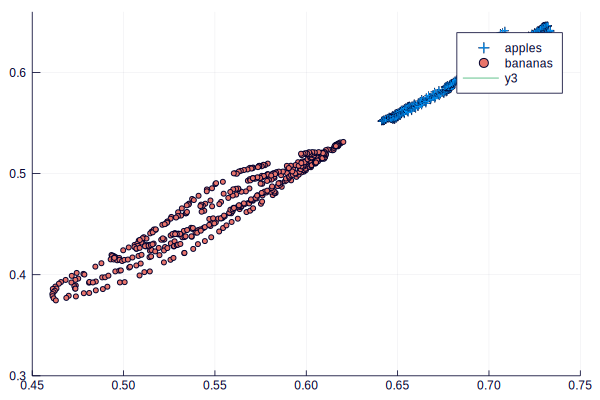

In [20]:
@manipulate for w1 in -2:0.01:3, w2 in -2:0.01:3, b in -2:0.01:3
    
    scatter(first.(x_apples), last.(x_apples), m=:cross, label="apples")
    scatter!(first.(x_bananas), last.(x_bananas), label="bananas")
    
    ylims!(0.3, 0.66)
    xlims!(0.45, 0.75)
    
    plot!(x -> -(w1*x + b) / w2)
end

## How can the neuron *learn* to classify the data?

We are now ready for our first experience of **machine learning**: we will let the neuron learn automatically by processing data and tuning model parameters accordingly (the process we call "learning")!

For given values of the parameters $w_1$, $w_2$ and $b$, the function $f_{\mathbf{w}, b}$ maps a vector of length $2$ to a number between $0$ and $1$ (due to the definition of $\sigma$). Now we want to have a neuron *learn* suitable values of these parameters. 

We want to discover (learn!) the parameters such that $f$ models the relationship between the data we explored above about the fruit images, and outputs a classification of the fruit: $0$ if it corresponds to an apple, and $1$ if it is a banana.

So the neuron's input will be a vector of 2 pieces of information about an image; let's call the data about the $i$th image $\mathbf{x}^{(i)}$.
We also are given the label that says which type of fruit it is: $0$ for an apple, and $1$ for a banana; let's call this *desired* output number $y^{(i)}$. When we feed in the $i$th data, $\mathbf{x}^{(i)}$, we want the neuron to give an output that is *as close as possible* to the desired output $y^{(i)}$; i.e. it should **minimize** the mean-squared distance

$$L_i = [f_{\mathbf{w}, b}(\mathbf{x}^{(i)}) - y^{(i)} ]^2.$$

However, now we see a key difference from what we did previously: the neuron should vary its parameters in such a way that it manages to minimize this distance for *all* of the input data, simultaneously!

How can we express this mathematically? We once again define a loss function, $L(\mathbf{w}, b)$, which tells us "how wrong" we are when the parameters take on the given values, and then **minimize** this loss function with respect to all of its parameters.

One way to take account of all the data at once is to use the "mean-squared error" loss function, which is the mean (squared) over all the differences between the output of the network, $f_{\mathbf{w}, b}(\mathbf{x}^{(i)})$ on the $i$th data, and the desired output $y^{(i)}$:

$$L_\mathrm{total}(\mathbf{w}, b) = \frac{1}{N} \sum_i L_i = \frac{1}{N} \sum_i [f_{\mathbf{w}, b}(\mathbf{x}^{(i)}) - y^{(i)} ]^2,$$

where $N$ is the total number of data in the training set.

Why do we choose this particular loss function? Because the minimum possible value of this loss function is $0$ (since it is a sum of squares), and this is reached only when the neural network perfectly predicts the output. If we can find a way to minimize this loss function, we will get as close as possible to this perfect prediction. (In general, though, we won't be able to get an exact prediction.)

## Minimizing the loss function: *stochastic* gradient descent

We already know how to minimise loss functions on a computer: we just calculate the gradient, and do gradient descent! But here we hit a problem: the function $L_\mathrm{total}$ usually has a *lot* of terms, and so calculating the gradient of that function will be very time-consuming.

Instead, we will use a variant of gradient descent, called *stochastic* gradient descent. Here, the idea is that we will not use the complete loss function; instead, at each step we will choose a random data point, number $i$, and do a step of gradient descent for the partial loss function $L_i$ *corresponding to only that data point*.

**Exercise 7:** 

Write functions for the partial loss function `L(w, b, x, y)`.

To do this, recall

$$
\mathbf{x} = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix};
\qquad
\mathbf{w} = \begin{pmatrix} w_1 \\ w_2 \end{pmatrix};
\qquad
f_{\mathbf{w}, b}(\mathbf{x}) = \sigma(\mathbf{w} \cdot \mathbf{x} + b),$$

and declare `f(x, w, b)` as in notebook 8.

#### Solution

First make sure you've declared

```julia
σ(x) = 1 / (1 + exp(-x))
f(x, w, b) = σ(w'x + b)
```
 
then declare your loss function as

```julia
L(w, b, x, y) = (f(x, w, b) - y)^2
```

**Tests**
```julia
isapprox(L([-1.5, 1.5], .5, [.3, .4], 1), 0.11764182271544733)
isapprox(L([-1, 1], 0, [-.4, -.3], 0), 0.27560314728604807)
```

#### Exercise 8

Write a function for the gradient of `L`, i.e. `∇L(w, b, x, y)`, with respect to the parameters $(w_1, w_2, b)$, using finite differences. $∇L$ will be a vector with one component per parameter:

$$∇L = \left( \frac{\partial L}{\partial w_1}, \frac{\partial L}{\partial w_2}, \frac{\partial L}{\partial b} \right).$$

#### Solution

First, you'll want to declare functions for your partial derivatives:

```julia
partial_w1(w, b, x, y, h = 0.001) = (C(w .+ [h, 0], b, x, y) - C(w, b, x, y))/h
partial_w2(w, b, x, y, h = 0.001) = (C(w .+ [0, h], b, x, y) - C(w, b, x, y))/h
partial_b(w, b, x, y, h = 0.001) = (C(w, b + h, x, y) - C(w, b, x, y))/h
```

which you can then use to declare ∇L:

```julia
∇L(w, b, x, y) = [partial_w1(w, b, x, y), partial_w2(w, b, x, y), partial_b(w, b, x, y)]
```

*Tests*:

```julia
isapprox(∇L([-1.5, 1.5], .5, [.3, .4], 1)[1], -0.04636839045066288)
isapprox(∇L([-1.5, 1.5], .5, [.3, .4], 1)[2], -0.061821518678797927)
isapprox(∇L([-1.5, 1.5], .5, [.3, .4], 1)[3], -0.15450877075851022)
isapprox(∇L([-1, 1], 0, [-.4, -.3], 0)[1], -0.10472487950158316)
isapprox(∇L([-1, 1], 0, [-.4, -.3], 0)[2], -0.07854532958612159)
isapprox(∇L([-1, 1], 0, [-.4, -.3], 0)[3], 0.2618900851394379)
```

#### Exercise 9

Implement stochastic gradient descent in the function `stochastic_gradient_descent(L, w, b, xs, ys, N = 1000)`. Use this function to minimize the function $L_\mathrm{total}$.

The algorithm: For each of `N` steps, randomly select an index $i$ into the vector `xs` storing your image data. Calculate the gradient of the cost function, $L_i$, for this image and update each of the parameters, $p_j$, of $L_i$ according to

$$p_j = p_j - 0.01 * ∇L_j$$

(Here, $j$ signifies the $j^{th}$ parameter of $L$ and similarly the $j^{th}$ component of $∇L$.)

`stochastic_gradient_descent` should return the updated values for vector $\mathbf{w}$ and scalar $b$.

Optional: Keep track of the value of $L_\mathrm{total}$ over time if you want to visualize the learning process.

#### Solution


```julia
function stochastic_gradient_descent(C, w, b, xs, ys, N=1000)

    η = 0.01

    for step in 1:N
        
        i = rand(1:length(xs))  # choose a data point
        
        x = xs[i]
        y = ys[i]
        
        grad = ∇C(w, b, x, y)
        w -= η * grad[1:2]
        b -= η * grad[3]
    end
    
    return w, b
    
end
```

**Tests**

```julia
w, b = ([0.736019, 0.518619], 0.03408673204690893)
w, b = stochastic_gradient_descent(C, w, b, xs, ys, 1e6)
-18.8 < w[1] < -18.4 # roughly -18.6 
-19.4 < w[2] < -19.0 # roughly -19.2
21 < b < 23 # roughly 22
```

#### Exercise 10

Use the values of `w` and `b` from the last exercise to see how `f` is classifying a couple of the images in out dataset.

In particular, calculate `f` using the 1st and the 900th image in `xs`. For which image is the output of `f` closer to the value of its label?

A) The output of `f` for the 1st image in `xs` is closer to its label

B) The output of `f` for the 900th image in `xs` is closer to its label.

#### Solution

A)

```julia
f(xs[900], w, b) # yields ~0.9565428318826446
ys[900] - f(xs[900], w, b) # yields ~.041 (4% difference)
f(xs[1], w, b) # yields ~0.027378537417953305
ys[1] - f(xs[1], w, b) # yields ~ -0.030 (3% difference)
```

We see that *with sufficient training*, the single neuron is approximately able to learn the function for most of the data, but not all:

#### Exercise 11

Use the `maximum` function to determine the maximum squared distance of the prediction from the true value. (For each image, this formula is $y_i - f_{w, b}(x_i)$.)

#### Solution

The  code
```julia
maximum((ys .- f.(xs, [w], [b])).^2)
```
yields `0.20570175481263825`.

#### Exercise 12

Use `w` and `b` from stochastic gradient descent to draw the function that the network has learned, as before, as the hyperplane $w_1 x + w_2 y + b = 0$. Overlay this with the data.


Does this hyperplane correctly separate the data? (I.e., is the data for all apples on one side of the line, and is the data for all bananas on the other side of the line?)

A) Yes
B) No

#### Solution

```julia
using Plots; gr()

plot(x ->(-w[1]*x - b) / w[2])
scatter!(first.(x_apples), last.(x_apples), m=:cross)
scatter!(first.(x_bananas), last.(x_bananas))
xlims!(0.45, 0.75)
ylims!(0.35, 0.75)
```

A) Yes

Since the neuron has two input variables and one output variable, we can also use a "heatmap" to visualize the value of $f_{\mathbf{w}, b}(x_1, x_2)$ as a function of the input data pairs $(x_1, x_2)$:

In [ ]:
heatmap(0:0.01:1, 0:0.01:1, (x,y) -> f([x,y], w, b))

scatter!(first.(x_apples), last.(x_apples), m=:cross)
scatter!(first.(x_bananas), last.(x_bananas))

xlims!(0.45, 0.75)
ylims!(0.35, 0.75)

We see that the single neuron has indeed *learned* to separate the data using a hyperplane.